# Covid-19 NLP topic association: Common word, sentence, and paper associations

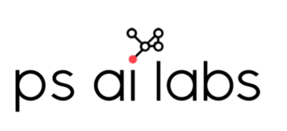

Submitted by Publicis Sapient AI Labs Data Scientists:  
Lauren Bittle, Sam Burck, Matthew Belley, Heather Rodney, Larry Berk, Deepa Mahidhara, Edoardo Turano, Ramon Perez

# Executive Summary

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19) that is being hosted by Kaggle. CORD-19 is a resource of over 51,000 scholarly articles, including over 40,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

Given the large amount of literature, it is difficult for health professionals to do meaningful searches of the data to find the most relevant papers for a particular question.

We applied a two-fold approach to mine relevant data from the CORD-19 dataset.  
* First, we implemented an AI framework that identifies word associations and similarity throughout the literature.   These word associations may be useful to inform policy makers, scientists, and experts of connected topics and to shed light on research directions that would otherwise be overlooked. 
* Second, we implemented a bi-directional sentence embedding approach that allows a user to extract relevant text from the literature as well the associated metadata (author, title, etc.) based on an input text query (i.e. asking a question).  


The utility of these two AI tools is that they allow an individual to extract relevant information from a very large data set with greater efficiency than a manually guided search.  Further, the word associations identified may be used as direct input to the question asking to yield insightful results.

For e.g. “What drugs inhibit glycoprotein?”   
Return sentence: 'In addition Koszalka summarized research performed on inhibitors of the glycoproteins gp120 and gp41'


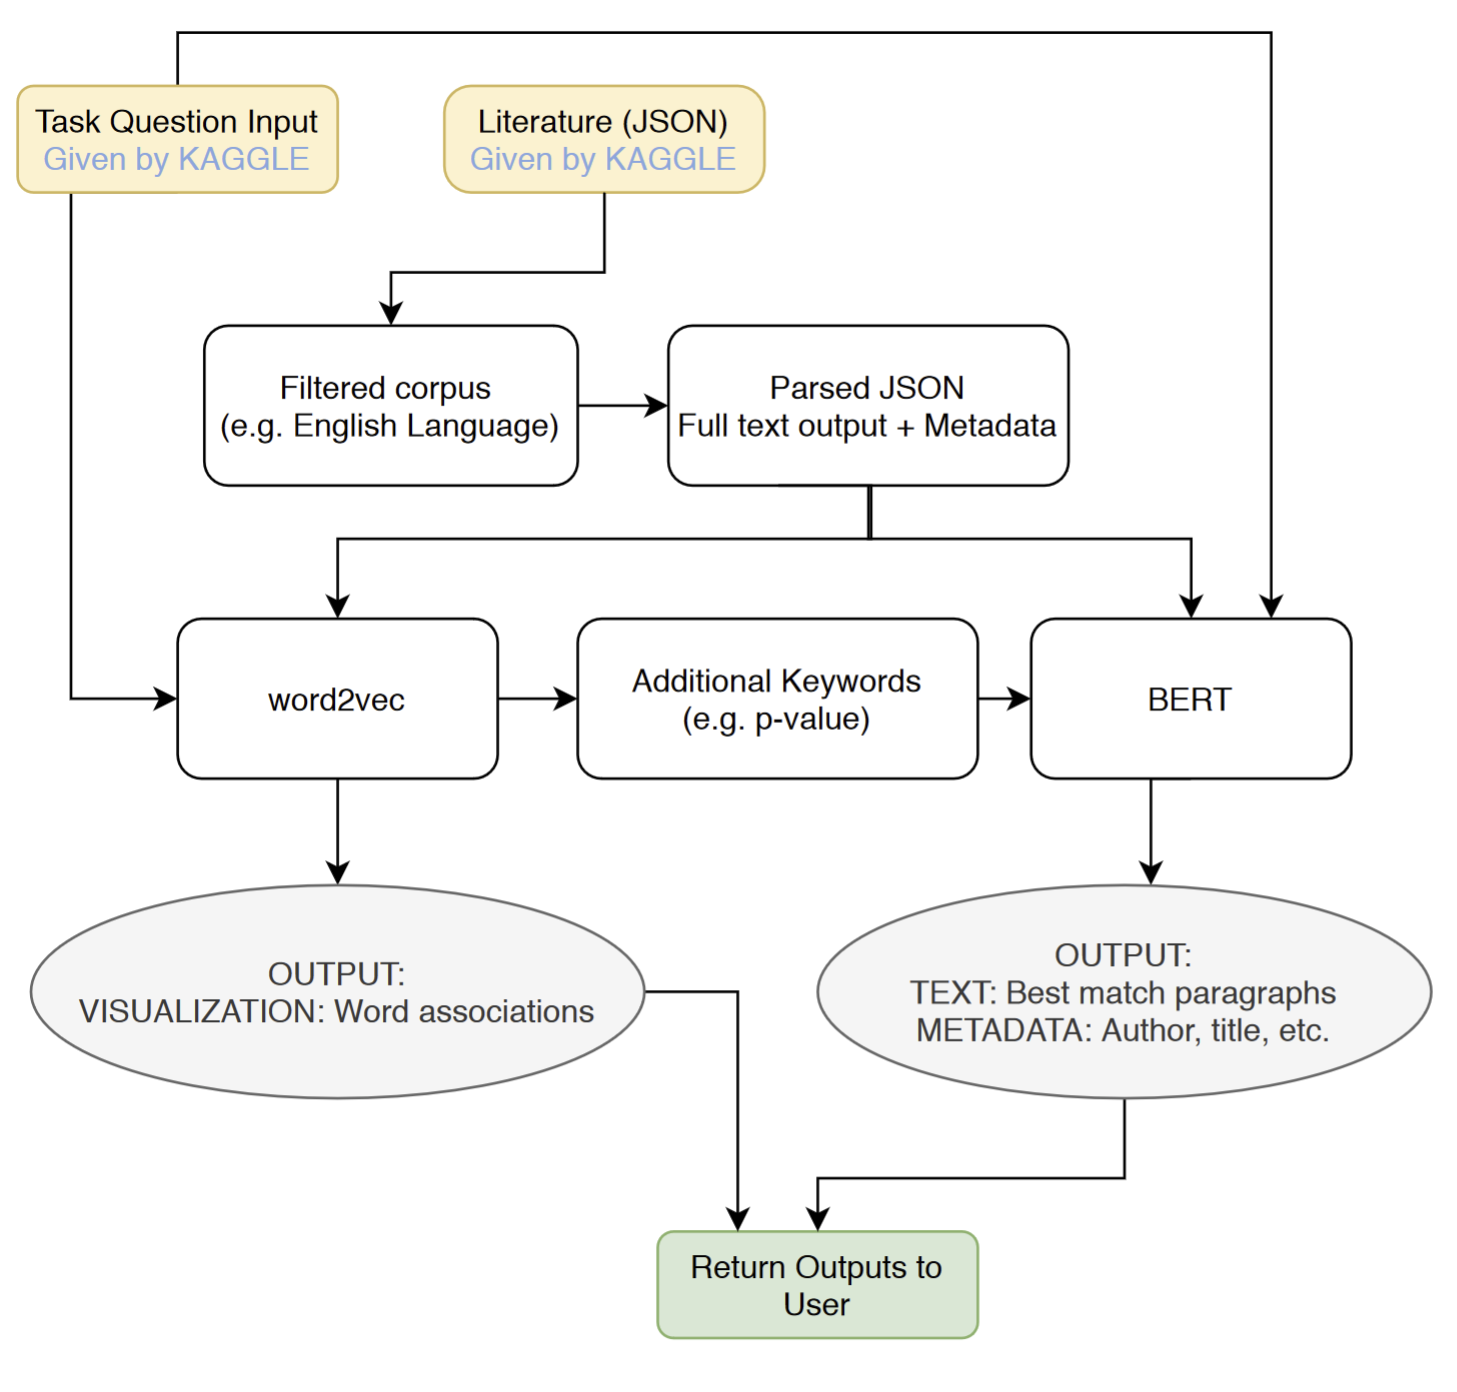

# Overview: 
* Data
* Modeling Approach
* Challenges & Next Steps


# Data
Our corpus from the CORD19 dataset is as of March 27th. It comprises of  ~44,000 documents, of which ~29,000 were with full text. We dropped ~2000 documents that were either not English or were pre-printed articles with not legible text. Using a NLP language detector, a paper had to be labeled as ‘English’, with a 99.99% probability of being in that language.

Filtering corpus: removing non-English papers  
Applied Spacy package's 'language detector' utility. (A pretrained model derived from postings to the internet.) For every paper, utility reports 1) most likely language and 2) probability paper is in that language. Built a set of document SHA and PMC ids.  Criterion: 1) language is English ('en') and 2) probability is 99.9% or better. The set is used to filter out English papers from the entire Kaggle corpus (pickled file).

Filtering corpus: removing preprint articles  
Based on the 4GB Kaggle download accessed on March 27th:  
~44k papers in the entire corpus  
~29k papers with JSON full text  
~950 papers are not classified as English (with sufficient certainty)

Preprint articles:  
Number JSON files with "preprint“ in the fulltext:	953  
Number JSON files with "allowed without permission" in the fulltext:	308  
954 of these preprint articles are unique; 944 can be matched to a metadata entry  

Less than 3% of the JSON corpus are “preprint” articles.Preprint articles often have garbled text, such as: 'CCBY 40 International license It is made available under a authorfunder who has granted medRxiv a license to display the preprint in perpetuityis the which was not peereviewed The copyright holder for this preprint ','URL doi medRxiv preprint'


# Modeling Approach
Based on the nature of the literature (science and virology), our theory was that a sciBERT model may be more appropriate for NLP as opposed to a standard BERT model.

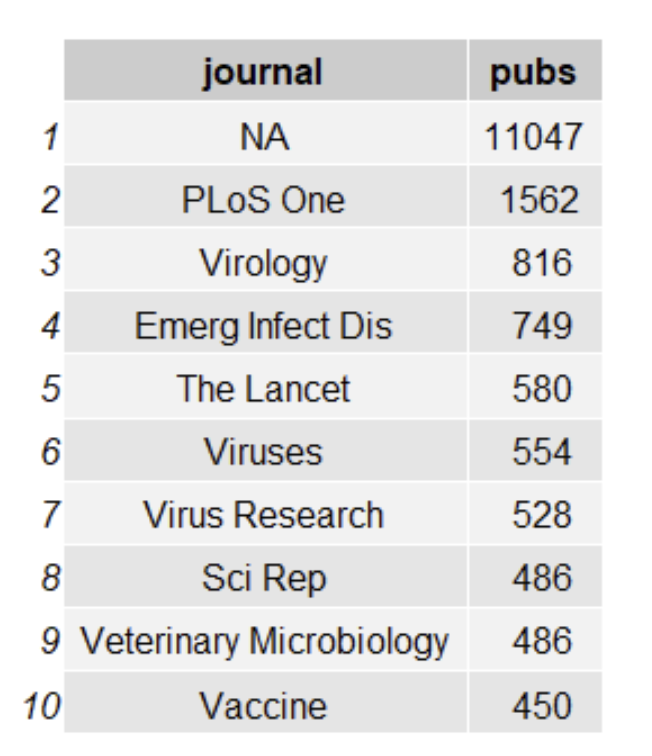

We analyzes CORD-19 data to assess vaccines and therapeutics with Word2Vec and BERT modeling of corpus. Each are stand-alone tools but can be used in tandem. Word2vec model explores word associations within the working corpus. 

BERT model determines most similar sentence(s) in corpus from custom sentence input (contextualized search). It can modify input with word associations from Word2vec.


## Word2Vec Association
We are using an approach based on a paper titled "Unsupervised word embeddings capture latent knowledge from materials science literature": https://www.nature.com/articles/s41586-019-1335-8

This notebook expands on the work done by Tarun Paparaju in his notebook titled "COVID-19 Dataset : Gaining actionable insights". His notebook can be found here: https://www.kaggle.com/tarunpaparaju/covid-19-dataset-gaining-actionable-insights

The idea here is to look for associations between keywords and other words which may be relevant but unknown. One can do this to, for example, look for unknown biomolecules related to a biomolecule that we know is integral to the coronavirus infecting a host. Doing this can help research progress in different directions that would otherwise not have been considered.

Topic Lookup: 
Next, we look up our words associated with our "lookup_word" on Wikipedia. Note that some Wikipedia summaries will be on topics related to a different case/use of the lookup_word. When this is the case, it makes sense to manually choose word/topics from the search results. Querying and displaying summaries for all search results would simply flood the notebook with too much text output.

The format for this output is:  
* lookup_word  
* Wikipedia search results  
* Summary

If no summary is found for the first search result for the lookup word's associated words, the code will attempt to lookup a summary for the associated word itself. If this fails, the code will attempt to find a summary from one of the remaining search results.


## BERT sentence similarity
Following along from the submission from gsarti https://github.com/gsarti/covid-papers-browser and the transformer code from https://github.com/UKPLab/sentence-transformers.

Bidirectional Encoding Representations for Transformers (BERT) models incorporate context into the word/sentence embeddings, increasing performance over other word embeddings that only consider each subsequent word. Specialty BERT models, such as sciBERT, are pretrained on scientific publications making this a strong candidate for analyzing the CORD-19 dataset.
Here we apply sciBERT encoding of the noted subset of the CORD-19 dataset to create a sentence similarity query. Each sentence is embedded as a vector, which is then compared to the input query also embedded with the same model. We use cosine distance to quantify the similarity between two vectors. The output return top-k sentence matches from unique papers, along with associated metadata (e.g., paper title), for the given input query.

Output:  
* ranking of result
* percent match ((1-distance)*100.)
* sentence index
* sha
* title
* authors
* single sentence (might do surrounding few sentences)

# Challenges & Next Steps
There is a large memory overhead to encode all sentences in the entire CORD19 corpus.  Therefore, we demonstrate a proof of concept with the bi-directional sentence encoding using a subset (n=1000) papers.  The method can be extended to the full corpus given additional memory and processing power.  Despite this limitation to a subset of the full CORD19 corpus, we have demonstrated the utility and power of combining two NLP models to create a comprehensive search tool.

As future steps, we would implement more targeted text pre-processing, particularly for bio-medical text, to more robustly handle technical terms and abbreviations.

# Importing python packages

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict, Counter
import pickle
import json
from tqdm.auto import tqdm
import pathlib
import sys

In [ ]:
!pip install wikipedia
import wikipedia

from gensim.test.utils import common_texts, get_tmpfile, datapath
from gensim.models import Word2Vec, KeyedVectors
from gensim import corpora
from gensim.summarization.textcleaner import split_sentences
from gensim.scripts.word2vec2tensor import word2vec2tensor
from pprint import pprint
import os.path
import nltk
import spacy
import re
import string
import os
from nltk.stem import WordNetLemmatizer
# from tqdm import tqdm
from multiprocessing import cpu_count

nltk.download('stopwords')
from nltk.corpus import stopwords

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import Tools.literature as lit

nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stopWords = set(stopwords.words('english'))

In [ ]:
!pip install sentence-transformers
from sentence_transformers import models, SentenceTransformer

import transformers
import torch
import scipy
import itertools
import bisect
# from tqdm import notebook as tqdm #print the entire progress bar on one row in a jupyter notebook
import csv
import gc


<a id='#load_data'></a>
# Loading CORD-19 JSON data into working corpus

<a id='load_corpus'></a>
## Importing the corpus
Load in the text from JSON using the custom python modules.

In [ ]:
# LITERATURE 

# -*- coding: utf-8 -*-

DataDir = pathlib.Path('../input/CORD-19-research-challenge/')
EngDir = pathlib.Path('../input/uploaded/')

mdFile = 'metadata.csv'
englishPapers = 'englishPapers.pkl'

idList = ['doi','pmcid','Microsoft Academic Paper ID','WHO #Covidence','sha']

class Container(dict):

    def __init__(self, **kwargs):
        dict.__init__(self, kwargs)
        self.__dict__ = self
        
class Literature():
    
    def __init__(self):
        self.maps = Container(PubmedToSha = {}, ShaToPubmed = {})
        self.metadata = pd.DataFrame(None)
        self.abstracts = pd.DataFrame(None)
        self.fullText = defaultdict(dict)
        self.englishPapers = {}
        
    def getMetaData(self, fn: str = mdFile, wd = DataDir):
        """
        Import the raw Kaggle metadata file
        Later; match to this dataFrame using sha values
        """
        self.metadata = pd.read_csv(wd / fn, sep=',', header=0)

    def createMaps(self):
        """
        Create two dictionaries: (k,v) = (Pubmed,Sha) and (k,v) = (Sha,Pubmed)
        The former is larger than the latter.  The former can map to an empty string, not the latter
        """
        foo = lambda x: x if type(x)==str else ''
        
        self.maps['PubmedToSha'] = {k:foo(v) for (k,v) in zip(self.metadata['pubmed_id'],self.metadata['sha'])}
        
        mask = [type(s) == str for s in self.metadata['sha']]
        filt = self.metadata[mask][['pubmed_id','sha']]
        self.maps['ShaToPubmed'] = {k:v for (k,v) in zip(self.metadata['sha'],self.metadata['pubmed_id'])}
        
    #Capture all main text data as a list. Some can be very deep json (as over 3,000 levels!)
    def getMainText(self,sha_set = None, path=DataDir):
        
        # this is full path
        f_list = set(path.rglob('*.json'))

        # Reduce f_list if sha_set is given 
        if(sha_set is not None):
            
            #sha_set needs .json extension
            sha_set = set([x + '.json' for x in sha_set])
            
            # build dictionary; base_path:full_path
            path_dict = {}
            for each in f_list:
                path_dict[os.path.basename(each)] = each
                        
            f_list = [full for base, full in path_dict.items() if base in sha_set]

        for paper in f_list:
        #        for paper in tqdm(path.rglob('*.json')):
            df_single = pd.read_json(paper,orient='index')

            # Catch errors
            try:
                bodyText = df_single.loc['body_text',:].values
                paragraphs = [x['text'] for j in range(len(bodyText)) for x in bodyText[j]]
                sha = paper.name.split('.')[0]
                self.fullText.update({sha:paragraphs})

            except:
                print('Missing text or failed to load for\n\t{}'.format(paper))
                raise
    '''
        Retrieve the set of SHA keys corresponding to English papers in the corpus.
        The user is expected to filter the contents of the Literature() object by this set.
        
        For instance, self.fullText is keyed by SHA, so use self.englishPapers as a filter.
        Likewise, filter PubMed->SHA and SHA->PubMed maps and metadata DF rows by english SHAs.
    '''          
    def getEnglishText(self,path=EngDir,papers=englishPapers):
        
        with open(path / papers, 'rb') as f:
            ep = pickle.load(f)
          
        self.englishPapers = ep

In [ ]:
# import Tools.literature as lit

print(DataDir)
print(EngDir)
print(mdFile)

reprocess = True
# data_source_aws = False
# if(data_source_aws): reprocess = False
    
if(reprocess):
    corpus = Literature()
    corpus.getMetaData()
#     corpus.getMainText() # might want to do this after identifying english papers?

## Selecting English Papers

Use pickle file of selected SHAs to read JSON files of subset of English-only papers.

In [ ]:
corpus.getEnglishText()
# type(corpus.englishPapers)

In [ ]:
# pass in the sha values we want 
corpus.getMainText(sha_set = corpus.englishPapers) # 5.5 GB RAM

In [ ]:
print(len(corpus.fullText.keys()))
# print(sys.getsizeof(corpus.fullText),sys.getsizeof(corpus.metadata))

In [ ]:
# with open('../data/corpus.pkl', 'rb') as f:
#     corpus = pickle.load(f)
# englishPapers = corpus.englishPapers
papers = [''.join(corpus.fullText[paperKey]) for paperKey in corpus.englishPapers]
# print(len(papers),sys.getsizeof(papers))
print('Number of papers: {}')

<a id='#w2v'></a>
# Word2vec associations

## Import PubMed vectors:
This is a set of key-value pairs generated by a word2vec model trained on a large set of pubmed data. Keys are words, values are embedded (vectorized) representations of those words.

In [ ]:
# PubMed model from https://www.ncbi.nlm.nih.gov/CBBresearch/Wilbur/IRET/DATASET/
# API Doc. https://radimrehurek.com/gensim/models/keyedvectors.html
pubWordVecs = KeyedVectors.load_word2vec_format('../input/pubmed/pubmed_s100w10_min.bin', binary=True)  # C bin format

## Checkout closest words to list of keywords, we will use this later:

In [ ]:
keywords = ["coronavirus", "infection", "fever", "pneumonia", "lung",\
            "cough","rna", "receptor", "cov", "antiviral"]
pubmedVecs = []
for word in keywords:
    word = lemmatizer.lemmatize(word)
    pubmedVecs.append((word, pubWordVecs.similar_by_word(word, topn=10)))

## Generating our own Word2Vec Model: Import data

## Preprocessing:
Put text into a format that can be used to train our model, and perform preprocessing to make our data more suitable for training a word2vec model.

In [ ]:
pickleExists = False

if os.path.isfile('../data/sentences.pkl'):
    pickleExists = True
    with open('../data/sentences.pkl', 'rb') as f:
        sentences = pickle.load(f)
    print("Sentences loaded from file.")
else:
    print('No sentence file, processing sentences.')
    allTxt = ''.join([''.join(paper) for paper in tqdm(papers) if type(paper)==str]) # Ensure no empty papers
    allTxt = re.sub(r'\.(?=[^ \W\d])','. ', allTxt)
    raw_sentences = split_sentences(allTxt)
    
    del allTxt

    raw_sentences = [[sentence] for sentence in tqdm(raw_sentences)]

In [ ]:
print(len(raw_sentences))

In [ ]:
# From https://www.geeksforgeeks.org/regex-in-python-to-put-spaces-between-words-starting-with-capital-letters/
def putSpace(input): 
    # Needed to split certain "joined sentences" such as ...coronavirusThe... where the first sentence ends
    # with "coronavirus" and the second one starts with "The"
    # regex [A-Z][a-z]* means any string starting with capital character
    # followed by many lowercase letters  
    words = re.findall('[A-Z][a-z]*', input) 
  
    # Change first letter of each word into lower 
    # case 
    result = [] 
    for word in words: 
        word = chr( ord (word[0]) + 32) + word[1:] 
        result.append(word) 
    return ' '.join(result)

def tokenizeSentence(sent):
    '''
        Process sentence:
            - Remove URL
            - Remove most punctuation
            - Tokenize words
            - Lemmatize sentence, throwing away tokens without letters (pure numbers)
                - Group together the inflected forms of a word so they can be analysed
                  as a single item, identified by the word's lemma, or dictionary form
    '''

    raw_sent = putSpace(sent[0])
    raw_sent = raw_sent.lower()
    raw_sent = re.sub(r'http\S+', 'URL', raw_sent, flags=re.MULTILINE)
    raw_sent = re.sub(r'[.!?]',' ', raw_sent)    
    raw_sent = re.sub(r'[^\w\s\-\+]','', raw_sent)
    split_sent = [word for word in raw_sent.split() if word not in stopWords and len(word)>2]
    sent = [lemmatizer.lemmatize(token) for token in sent if not token.isdigit() and token not in stopWords]
    if split_sent:
        return split_sent

if pickleExists==False:    
    sentences = [tokenizeSentence(sent) for sent in tqdm(raw_sentences)]
    sentences = list(filter(None, sentences))
#     with open('../data/sentences.pkl', 'wb') as f:
#         corpus = pickle.dump(sentences, f)

In [ ]:
del raw_sentences

## Load or train word2vec model:

In [ ]:
vecsExist = False
if os.path.isfile('../data/KaggleVecs.bin'):
    print('Embedding file found, loading...')
    vecsExist = True
    kaggleWordVecs = KeyedVectors.load_word2vec_format('../data/KaggleVecs.bin', binary=True)  # C bin format

if vecsExist==False:
    print('Training Word2Vec model...')
    # Model will default to vecs of length 100 unless told otherwise in size arg.
    model = Word2Vec(sentences, size=200, min_count=0, workers=cpu_count())
    kaggleWordVecs = model.wv
#     kaggleWordVecs.save_word2vec_format('../input/w2vdata/KaggleVecs.bin', binary=True)
    del model

## Compare results to those from pubmed embeddings:

This will give insight into how our model trained on the Covid-19 dataset compares to a model trained on general medical literature.

In [ ]:
keywords = ["coronavirus", "infection", "fever", "pneumonia", "lung",\
            "cough","rna", "cov", "antiviral"]

kaggleVecs = []
for word in keywords:
    kaggleVecs.append((lemmatizer.lemmatize(word), kaggleWordVecs.similar_by_word(word, topn=3)))

In [ ]:
for pubmed, kaggle in zip(pubmedVecs, kaggleVecs):
    print('\nPubmed:')
    pprint(pubmed)
    print('\nKaggle:')
    pprint(kaggle)

## Topic Lookup:


In [ ]:
lookup_word = 'inhibitors'
try:
    for word in kaggleWordVecs.similar_by_word(lookup_word.lower(), topn=3):
        word = lemmatizer.lemmatize(word[0])
        print(word, '\n')
        searchResults = wikipedia.search(word)
        if searchResults:
            print(searchResults, '\n')
            try:
                print(searchResults[0] + ': ' + wikipedia.summary(searchResults[0]), '\n')
            except:
                try:
                    print(word + ': ' + wikipedia.summary(word), '\n')
                except:
                    for word in searchResults:
                        try:
                            print(next_word + ': ' + wikipedia.summary(next_word), '\n')
                            break
                        except:
                            continue
                        
        else:
            print('No search results for', word[0], '\n')
except KeyError:
    print(lookup_word, "not found in vocabulary.")

We found that the word "glycoprotein" has the closest association to our lookup word, inhibitors. The image below is a closeup of from within the cluster containing the word inhibitor.

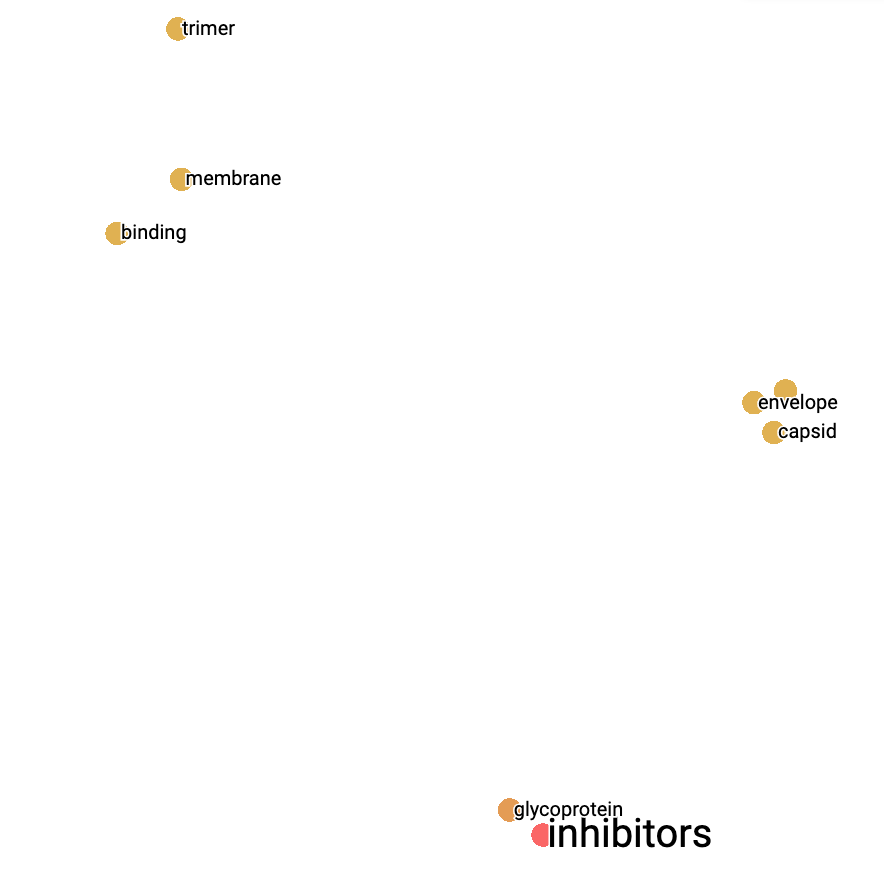
Generated with t-SNE using https://projector.tensorflow.org/


## Removing variables unique to word2vec model

In [ ]:
# keep raw_sentences_str, papers
del sentences
kaggleVecs = []
del kaggleWordVecs

<a id='#bert'></a>
# Running sciBERT sentence similarity on corpus

<a id='load_model'></a>
## Models

In [ ]:
MODELS_PRETRAINED = {
    'scibert': 'allenai/scibert_scivocab_cased',
    'biobert': 'monologg/biobert_v1.1_pubmed',
    'covidbert': ' deepset/covid_bert_base',
}

MODELS_FINETUNED = {
    'scibert-nli': 'gsarti/scibert-nli',
    'biobert-nli': 'gsarti/biobert-nli',
    'covidbert-nli': 'gsarti/covidbert-nli'
}

MODELS = {**MODELS_PRETRAINED, **MODELS_FINETUNED}

#### Set the desired model - here scibert-nli

In [ ]:
my_model = 'scibert-nli'
MODELS[my_model]

Initiate the model with word embedding for each sentence then mean pooling to create a sentence embedding (vector).

In [ ]:
if my_model in MODELS_FINETUNED.keys():# Build the SentenceTransformer directly
    word_embedding_model = models.BERT(
        MODELS[my_model],
        max_seq_length=128, 
        do_lower_case=True 
    )
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                           pooling_mode_mean_tokens=True,
                           pooling_mode_cls_token=False,
                           pooling_mode_max_tokens=False)
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
else:
    print('No BERT model found')

## Work on a subset of the data for now 

#### Set number of papers (stop_at) to encode with BERT model

Here we work with a subset of the working corpus to run the model encoding (embedding) and return some results.

In [ ]:
# Number of papers to work with
# negative 1 (-1) means use full corpus

stop_at = 1000

In [ ]:
if(stop_at == -1):
    a = corpus.fullText
    del corpus.fullText
    
else:    
    # Take n papers for now
    a = {}
    count = 0
    for k,v in corpus.fullText.items():
        if(count >= stop_at): break
        count +=1
        a.update({k:v})

In [ ]:
len(corpus.fullText), len(a)

In [ ]:
ALL_INFO = pd.DataFrame(data=a.items(), columns=['sha', 'full_text'])

In [ ]:
# Creating a master list containing a list of each paper text
paper_txt = ALL_INFO['full_text']

# Defining list of sha values in order of corpus sentence text
sha_list = ALL_INFO['sha']


In [ ]:
ALL_INFO['paper_sent'] = ALL_INFO['full_text'].astype(str).apply(split_sentences)

In [ ]:
# Counting the number of sentences per paper PRIOR TO CLEANING
ALL_INFO['n_sentences_PRIOR'] = ALL_INFO.paper_sent.apply(len)

In [ ]:
def clean_sent(sent):
    '''
        Process sentence:
            - Remove URL
            - Remove punctuation
        model.encode() DOES NOT accept NoneType
    '''
    sent = re.sub(r'http\S+', 'URL', sent, flags=re.MULTILINE)
    sent = re.sub(r'[^\w\s]','', sent)
    if sent:
        return sent

In [ ]:
ALL_INFO['cleaned'] = ALL_INFO.paper_sent.apply(lambda x: [clean_sent(y) for y in x])

In [ ]:
ALL_INFO['cleaned'] = ALL_INFO.cleaned.apply(lambda x: [y for y in x if (y is not None)])#
ALL_INFO['cleaned'] = ALL_INFO.cleaned.apply(lambda x: [y for y in x if len(y) > 25])#[len(y) for y in x ])#if len(y) > 20])

In [ ]:
# Counting the number of sentences per paper
ALL_INFO['n_sentences'] = ALL_INFO.cleaned.apply(len)
ALL_INFO['cum_sum'] = ALL_INFO.n_sentences.cumsum()

In [ ]:
cleaned_corpus_sent = list(itertools.chain(*ALL_INFO['cleaned']))


In [ ]:
# Look up SHA from index of sentence with bisect method
def get_sha(index_list, sha_list, sent_idx):
    p_ind = bisect.bisect_right(index_list, sent_idx)
    return sha_list[p_ind]

In [ ]:
test_sha = get_sha(ALL_INFO.cum_sum.astype(int), ALL_INFO.sha.astype(str), 110)
print(test_sha)
print(corpus.metadata[corpus.metadata.sha == test_sha].authors)

<a id='emb_corpus'></a>
## Producing sentence embeddings for the corpus with model
Embedding each sentence of the working corpus. This may require several hours depending on size of working corpus.

In [ ]:
cleaned_corpus_sent_emb = model.encode(cleaned_corpus_sent, show_progress_bar=True)

<a id='#answers'></a>
## Question function: Querying by cosine distance

Define function to take query and search the (embedded) corpus for best matching sentence by cosine distance. If multiple sentences from a single paper (i.e., SHA value) in top-k, return only top for each paper so that top-k results are unique papers. Count of paper frequency is considered until top-k unique results are returned.

Adapted from https://github.com/gsarti/covid-papers-browser/blob/master/scripts/interactive_search.py

Output:  
* ranking of result
* percent match ((1-distance)*100.)
* sentence index
* sha
* title
* authors
* single sentence (might do surrounding few sentences)

In [ ]:
def ask_question(query
                 , model
                 , index_list
                 , sha_list
                 , corpus_meta
                 , corpus_text
                 , corpus_embed
                 , top_k=5):
    """
    Adapted from https://www.kaggle.com/dattaraj/risks-of-covid-19-ai-driven-q-a

    query: input question being asked of the corpus
    model: model used to encode sentences
    index_list: list of non-inclusive ending index of paper sentence index values (cumulative)
    sha_list: list of SHA ids
    corpus_meta: corpus variable that contains the metadata (i.e., corpus.metadata)
    corpus_text: single list of corpus sentences (text)
    corpus_embed: encoded corpus of sentences for all papers (vectors)
    top_k: top k results to be returned
    
    """
    # Read and encode queries
    queries = [query]
    query_embeds = model.encode(queries, show_progress_bar=False)
    
    # Loop through list of input queries
    for query, query_embed in zip(queries, query_embeds):
        
        # Calculate cosine distance of query to corpus sentence embeddings and sort
        distances = scipy.spatial.distance.cdist([query_embed], corpus_embed, "cosine")[0]
        distances = zip(range(len(distances)), distances)
        distances = sorted(distances, key=lambda x: x[1])
        
        # Initiate results to be returned and printed
        sha_results = []
        
        #while loop to keep track of sha count? max counters will be k 
        for count, (idx, distance) in enumerate(distances[0:100]): #(distances[0:top_k*10])
            
            #get SHA value based on index of
            sent_sha = get_sha(index_list, sha_list, idx)
            
            #add check that not from same paper (keep count, return unique papers)
            if sent_sha not in sha_results:
                sha_results.append(sent_sha)
                print('Result #{0} ({1}%):\nINDEX: {2}\n SHA: {3}\n TITLE: {4}\n AUTHOR(S): {5}\n EXCERPT: {6}\n\n\
                      '.format(count + 1
                                , round((1 - distance)*100., 2) #round(1 - distance, 4)
                                , idx
                                , sent_sha
                                , [corpus_meta[corpus_meta.sha == sent_sha].title]
                                , [corpus_meta[corpus_meta.sha == sent_sha].authors]
                                , '. '.join(corpus_text[idx-2:idx+3]) )) #return a few sentences surrounding matched sentence

            else:
                sha_results.append(sent_sha)

            if len(Counter(sha_results).keys()) == top_k:
                break

        print(Counter(sha_results))

    return

<a id='asking'></a>
## Ask your question!
Write your query below.

In [ ]:
my_query = 'What is  glycoprotein structure?'

Set number (k) of results to return.

In [ ]:
# How many top results to print
n_results = 5

Run the query.

In [ ]:
ask_question(my_query
                 , model
                 , ALL_INFO['cum_sum'] #paper_sentidx
                 , ALL_INFO['sha'] #sha_list
                 , corpus.metadata
                 , cleaned_corpus_sent
                 , cleaned_corpus_sent_emb
                 , top_k=n_results)


# ALL_INFO.columns() #'sha', 'full_text', 'paper_sent', 'n_sentences_PRIOR', 'cleaned', 'n_sentences', 'cum_sum'